In [1]:
%matplotlib inline

In [2]:
import logging

logger = logging.getLogger('planet4.clustering')

ch = logging.StreamHandler()
logger.addHandler(ch)

In [9]:
logger.setLevel(logging.DEBUG)

In [3]:
logger.setLevel(logging.INFO)

In [112]:
%%writefile ../planet4/dbscan.py
from scipy.stats import circmean
from sklearn.cluster import DBSCAN
import seaborn as sns
from planet4 import markings
from itertools import product

def get_average_objects(clusters, kind):
    """Create the average object out of a sequence of clusters.

    Parameters
    ----------
    clusters : sequence of pandas.DataFrames
        table with rows of markings (fans or blotches) to be averaged
    kind : {'fan', 'blotch}
        Switch to control the circularity for the average angle calculation.
    
    Returns
    -------
    Generator providing single row pandas.DataFrames with the average values
    """
    logger.debug("Averaging clusters.")
    for cluster_df in clusters:
        # first filter for outliers more than 1 std away
        # for
        # reduced = df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 1).all(axis=1)]
        meandata = cluster_df.mean()
        # this determines the upper limit for circular mean
        high = 180 if kind == 'blotch' else 360
        avg = circmean(cluster_df.angle, high=high)
        meandata.angle = avg
        yield meandata.to_frame().T


def plot_results(p4id, labels, data=None, kind=None, reduced_data=None, ax=None):
    functions = dict(blotch=p4id.plot_blotches,
                     fan=p4id.plot_fans)
    if ax is None:
        fig, ax = plt.subplots()

    plot_kwds = {'alpha': 0.8, 's': 10, 'linewidths': 0}
    palette = sns.color_palette('bright', len(labels))
    cluster_colors = [palette[x] if x >= 0 else (0.75, 0.75, 0.75)
                      for x in labels]
    p4id.show_subframe(ax=ax)
    if data is not None:
        ax.scatter(data.loc[:, 'x'], data.loc[:, 'y'], c=cluster_colors,
                   **plot_kwds)
    markings.set_subframe_size(ax)
    # pick correct function for kind of marking:
    if reduced_data is not None:
        functions[kind](ax=ax, data=reduced_data, lw=1)


class DBScanner(object):
    """Potential replacement for ClusteringManager
    
    Parameters
    ----------
    img_id : str
        planet4 image_id string. Can be the right-hand minimal identifier,
        lik 'pbr', will be padded to the full one.
    """
    # For cluster_angle:
    # calculated value of euclidean distance of unit vector
    # end points per degree
    eps_per_degree = 2 * np.pi / 360

    # shortcut translator
    t = dict(b='blotch',
             f='fan',
             blotch='blotch',
             fan='fan')

    def __init__(self, img_id):
        self.img_id = img_id
        self.p4id = markings.ImageID(img_id, scope='planet4')
        self.plot_functions = dict(fan=self.p4id.plot_fans,
                                   blotch=self.p4id.plot_blotches)

    def show_markings(self):
        self.p4id.plot_all()
        
    def cluster_any(self, X, eps, min_samples):
        logger.debug("Clustering any.")
        db = DBSCAN(eps, min_samples).fit(X)
        labels = db.labels_
        unique_labels = sorted(set(labels))

        core_samples_mask = np.zeros_like(labels, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True

        self.n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
        logger.debug("%i clusters found.", self.n_clusters)

        self.labels = labels

        # loop over unique labels.
        for k in unique_labels:
            class_member_mask = (labels == k)
            if k == -1:
                continue
            indices = class_member_mask & core_samples_mask
            logger.debug("%i cluster members in this cluster.", np.count_nonzero(indices))
            yield indices

    def cluster_xy(self, kind, eps, min_samples):
        logger.debug("Clustering x,y.")
        kind = self.t[kind]
        data = self.p4id.filter_data(kind)
        X = data[['x', 'y']].as_matrix()
        for cluster_index in self.cluster_any(X, eps, min_samples):
            yield data.loc[cluster_index]
                
    def cluster_and_plot(self, kind, eps, min_samples, ax=None, fontsize=None):
        kind = self.t[kind]
        xyclusters = self.cluster_xy(kind, eps, min_samples)
        averaged = get_average_objects(xyclusters, kind)
        try:
            reduced_data = pd.concat(averaged, ignore_index=True)
        except ValueError as e:
            if e.args[0].startswith("No objects to concatenate"):
                reduced_data = None
                n_reduced = 0
        else:   
            n_reduced = len(reduced_data)

        if ax is None:
            fig, ax = plt.subplots()
        plot_results(self.p4id, self.labels, kind=kind,
                     reduced_data=reduced_data, ax=ax)
        ax.set_title("MS: {}, EPS: {}\nn_clusters: {}, averaged: {}"
                     .format(min_samples, eps, self.n_clusters, n_reduced),
                     fontsize=fontsize)

    def cluster_angles(self, kind, xy_clusters,
                       min_samples,
                       eps_fanangle=20,
                       eps_blotchangle=20):
        logger.debug("Clustering angles.")
        cols_to_cluster = dict(blotch=['y_angle'],
                               fan=['x_angle', 'y_angle'])
        kind = self.t[kind]
        eps_degrees = eps_fanangle if kind == 'fan' else eps_blotchangle
        # convert to radians
        eps = eps_degrees * self.eps_per_degree
        for xy_cluster in xy_clusters:
            X = xy_cluster[cols_to_cluster[kind]]
            for indices in self.cluster_any(X, eps, min_samples):
                yield xy_cluster.loc[indices]

    def pipeline(self, kind, eps, min_samples, with_angles=True):
        kind = self.t[kind]
        xyclusters = self.cluster_xy(kind, eps, min_samples)
        if with_angles:
            finalclusters = self.cluster_angles(kind, xyclusters, min_samples)
        else:
            finalclusters = xyclusters
        averaged = get_average_objects(finalclusters, kind)
        try:
            reduced_data = pd.concat(averaged, ignore_index=True)
        except ValueError as e:
            if e.args[0].startswith("No objects to concatenate"):
                print("No clusters survived.")
                return
            else:
                raise e
        return reduced_data
    
    def parameter_scan(self, kind, msf_values, eps_values, do_scale=False):
        kind = self.t[kind]
        fig, ax = plt.subplots(nrows=len(msf_values),
                               ncols=len(eps_values) + 1,
                               figsize=(10,5))
        axes = ax.flatten()
        for ax, (msf, eps) in zip(axes, product(msf_values, eps_values)):
            min_samples = round(msf * self.p4id.n_marked_classifications)
            self.cluster_and_plot(kind, eps, min_samples, ax=ax, fontsize=8)
        
        # plot input tile
        self.p4id.show_subframe(ax=axes[-1])
        axes[-1].set_title("Input tile", fontsize=8)
        # plot marking data
        self.plot_functions[kind](ax=axes[-2], lw=0.25, with_center=True)
        axes[-2].set_title("{} marking data".format(kind), fontsize=8)
        fig.suptitle("n_class: {}, scale: {}"
                     .format(self.p4id.n_marked_classifications, do_scale))
        savepath = ("plots/{}/{}_scale{}.png"
                    .format(kind, self.img_id, do_scale))
        fig.savefig(savepath, dpi=200)

                


Overwriting ../planet4/dbscan.py


In [107]:
dbscanner = DBScanner('1dt')

Averaging clusters.
Clustering x,y.
Clustering any.
4 clusters found.
3 cluster members in this cluster.
22 cluster members in this cluster.
10 cluster members in this cluster.
9 cluster members in this cluster.


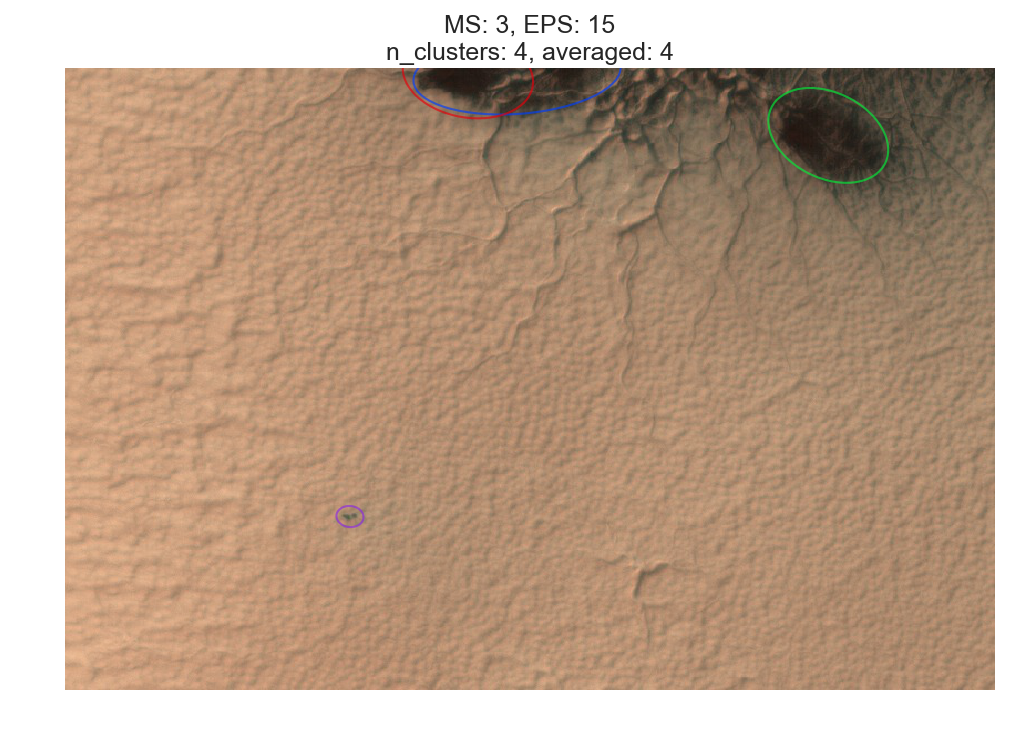

In [108]:
dbscanner.cluster_and_plot('b', 15, 3)

In [109]:
dbscanner.pipeline('b', 15, 3 )

Averaging clusters.
Clustering angles.
Clustering x,y.
Clustering any.
4 clusters found.
3 cluster members in this cluster.
Clustering any.
1 clusters found.
3 cluster members in this cluster.
22 cluster members in this cluster.
Clustering any.
1 clusters found.
21 cluster members in this cluster.
10 cluster members in this cluster.
Clustering any.
2 clusters found.
3 cluster members in this cluster.
7 cluster members in this cluster.
9 cluster members in this cluster.
Clustering any.
2 clusters found.
4 cluster members in this cluster.
3 cluster members in this cluster.


,x_tile,y_tile,x,y,image_x,image_y,radius_1,radius_2,distance,angle,spread,version,x_angle,y_angle
0,1.0,59.0,408.666667,6.666667,408.666667,31790.666667,93.850832,41.543054,NaN,174.947767,NaN,NaN,-0.995365,0.087983
1,1.0,59.0,689.785714,71.285714,689.785714,31855.285714,61.735872,44.406258,NaN,38.106649,NaN,NaN,0.714050,0.609319
2,1.0,59.0,357.333333,10.666667,357.333333,31794.666667,81.910553,62.631565,NaN,59.206824,NaN,NaN,0.467436,0.817359
3,1.0,59.0,367.285714,6.571429,367.285714,31790.571429,50.273352,35.792705,NaN,4.737699,NaN,NaN,0.130440,0.117714
4,1.0,59.0,257.500000,468.000000,257.500000,32252.000000,10.000000,10.000000,NaN,0.000000,NaN,NaN,1.000000,0.000000
5,1.0,59.0,255.833333,465.666667,255.833333,32249.666667,16.901193,12.749627,NaN,28.015704,NaN,NaN,0.880127,0.468135


Averaging clusters.
Clustering x,y.
Clustering any.
4 clusters found.
22 cluster members in this cluster.
1 cluster members in this cluster.
8 cluster members in this cluster.
9 cluster members in this cluster.
Averaging clusters.
Clustering x,y.
Clustering any.
4 clusters found.
3 cluster members in this cluster.
22 cluster members in this cluster.
10 cluster members in this cluster.
9 cluster members in this cluster.
Averaging clusters.
Clustering x,y.
Clustering any.
3 clusters found.
17 cluster members in this cluster.
22 cluster members in this cluster.
9 cluster members in this cluster.
Averaging clusters.
Clustering x,y.
Clustering any.
3 clusters found.
19 cluster members in this cluster.
5 cluster members in this cluster.
9 cluster members in this cluster.
Averaging clusters.
Clustering x,y.
Clustering any.
3 clusters found.
22 cluster members in this cluster.
9 cluster members in this cluster.
9 cluster members in this cluster.
Averaging clusters.
Clustering x,y.
Clustering a

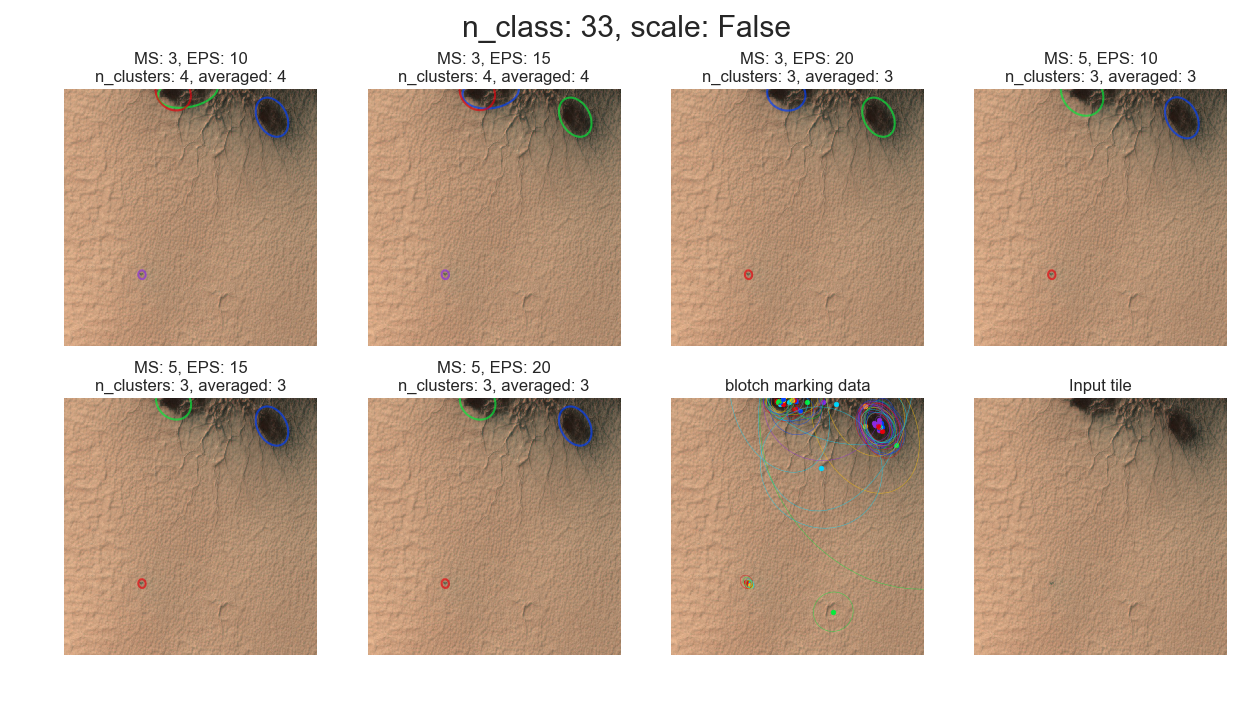

In [110]:
dbscanner.parameter_scan('blotch', msf_values=[0.1, 0.15], eps_values=[10,15,20])